In [13]:
%matplotlib notebook
import numpy as np
import os
import sys
np.random.seed(0)
import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import SubsetRandomSampler
import matplotlib
from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
sys.path.append(r'C:\lior\studies\master\projects\calibration\regression calibration\regression_calibration')
os.chdir(r'C:\lior\studies\master\projects\calibration\regression calibration\regression_calibration')
from src.data.data_generator_oct import OCTDataset
from models import BreastPathQModel
from uce import uceloss
from src.features.calibration_plots import plot_uncert, plot_frequency, plot_uncert_multi
from utils import nll_criterion_gaussian, avg_len

matplotlib.rcParams['font.size'] = 8

In [14]:
base_model = 'efficientnetb4'

In [15]:
assert base_model in ['resnet101', 'densenet201', 'efficientnetb4']
device = torch.device("cuda:0")

In [16]:
batch_size = 16
resize_to = (256, 256)

data_dir = 'C:/lior/studies/master/projects/calibration/regression calibration/3doct-pose-dataset/data/'
data_set = OCTDataset(data_dir=data_dir, augment=False, resize_to=resize_to)
assert len(data_set) > 0

calib_indices = torch.load('./data_indices/oct_valid_indices.pth')
test_indices = torch.load('./data_indices/oct_test_indices.pth')

print(calib_indices.shape)
print(test_indices.shape)

calib_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                           sampler=SubsetRandomSampler(calib_indices))
test_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size,
                                          sampler=SubsetRandomSampler(test_indices))

torch.Size([850])
torch.Size([850])


In [18]:
from glob import glob
model = BreastPathQModel(base_model, out_channels=6).to(device)

# checkpoint_path = glob(f"C:\lior\studies\master\projects\calibration/regression calibration/regression_calibration\models\snapshots\{base_model}_gaussian_oct_best_freeze_lr_0.0003_nll.pth.tar")[0]
checkpoint_path = glob(f"C:\lior\studies\master\projects\calibration/regression calibration/regression_calibration\models\snapshots\{base_model}_gaussian_oct_499.pth.tar")[0]
# checkpoint_path = glob(f"C:\lior\studies\master\projects\calibration/regression calibration/regression_calibration\models\snapshots\{base_model}_gaussian_oct_315.pth.tar")[0]

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])
print("Loading previous weights at epoch " + str(checkpoint['epoch']) + " from\n" + checkpoint_path)

Loading previous weights at epoch 499 from
C:\lior\studies\master\projects\calibration/regression calibration/regression_calibration\models\snapshots\efficientnetb4_gaussian_oct_499.pth.tar


In [6]:
model.eval()
y_p_calib = []
vars_calib = []
logvars_calib = []
targets_calib = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(calib_loader)):
        data, target = data.to(device), target.to(device)

        y_p, logvar, var_bayesian = model(data, dropout=True, mc_dropout=True, test=True)

        y_p_calib.append(y_p.detach())
        vars_calib.append(var_bayesian.detach())
        logvars_calib.append(logvar.detach())
        targets_calib.append(target.detach())

100%|██████████| 54/54 [01:43<00:00,  1.91s/it]


In [7]:
y_p_calib = torch.cat(y_p_calib, dim=1).clamp(0, 1).permute(1,0,2)
print(y_p_calib.shape)
mu_calib = y_p_calib.mean(dim=1)
var_calib = torch.cat(vars_calib, dim=0)
logvars_calib = torch.cat(logvars_calib, dim=1).permute(1,0,2)
logvar_calib = logvars_calib.mean(dim=1)
target_calib = torch.cat(targets_calib, dim=0)

torch.Size([850, 25, 6])


In [8]:
import pickle

save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/well-calibrated-regression-uncertainty/var_and_mse_calib/'
with open(save_path + f'{base_model}_gaussian_oct_best_freeze_lr_0.0003_nll_mu_target_calib.pickle', 'wb') as handle:
    pickle.dump({'mu_calib': mu_calib, 
                 'target_calib': target_calib}
                , handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
import pickle

save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/well-calibrated-regression-uncertainty/var_and_mse_calib/'
with open(save_path + f'{base_model}_gaussian_oct_best_freeze_lr_0.0003_nll_mu_target_calib.pickle', 'rb') as handle:
    mu_dict = pickle.load(handle)
    mu_calib = mu_dict['mu_calib']
    target_calib = mu_dict['target_calib']

In [8]:
err_calib = (target_calib-mu_calib).pow(2).mean(dim=1, keepdim=True).sqrt()
errvar_calib = (y_p_calib-target_calib.unsqueeze(1).repeat(1,25,1)).pow(2).mean(dim=(1,2)).unsqueeze(-1)

uncertainty = 'aleatoric'

uncert_calib_aleatoric = logvar_calib.exp().mean(dim=1, keepdim=True)
uncert_calib_epistemic = var_calib.mean(dim=1, keepdim=True)

if uncertainty == 'aleatoric':
    uncert_calib = uncert_calib_aleatoric.sqrt().clamp(0, 1)
    uncert_calib_laves = (uncert_calib_aleatoric + uncert_calib_epistemic).sqrt().clamp(0, 1)  # total
elif uncertainty == 'epistemic':
    uncert_calib = uncert_calib_epistemic.sqrt().clamp(0, 1)
else:
    uncert_calib = (uncert_calib_aleatoric + uncert_calib_epistemic).sqrt().clamp(0, 1)  # total

In [68]:
print((err_calib**2).mean())
print(errvar_calib.mean())
print((uncert_calib**2).mean())
print(uncert_calib_aleatoric.sqrt().mean())
print(uncert_calib_epistemic.sqrt().mean())

#err_calib = errvar_calib.sqrt()

tensor(0.0015, device='cuda:1')
tensor(0.0016, device='cuda:1')
tensor(0.0002, device='cuda:1')
tensor(0.0144, device='cuda:1')
tensor(0.0135, device='cuda:1')


In [69]:
fig, ax = plt.subplots(1)
ax.plot(uncert_calib.cpu(), err_calib.cpu()[:,0], '.')

max_val = max(err_calib.max().item(), uncert_calib.max().item())
ax.plot([0, max_val], [0, max_val], '--')
ax.set_xlabel('uncert')
ax.set_ylabel('err')
plt.show()

<IPython.core.display.Javascript object>

In [9]:
# calculate optimal T
S = (err_calib**2 / uncert_calib**2).mean().sqrt()
print(S)

tensor(1.7532, device='cuda:0')


In [12]:
class Scaler(torch.nn.Module):
    def __init__(self, init_S=1.0):
        super().__init__()
        self.S = torch.nn.Parameter(torch.tensor([init_S]))

    def forward(self, x):
        return self.S.mul(x)

In [13]:
# find optimal S
scaler = Scaler(init_S=S).to(device)
s_opt = torch.optim.LBFGS([scaler.S], lr=3e-2, max_iter=200)

def closure():
    s_opt.zero_grad()

    loss = nll_criterion_gaussian(mu_calib, scaler(uncert_calib).pow(2).log(), target_calib)

    loss.backward()
    return loss

s_opt.step(closure)
print(scaler.S.item())

0.8700129985809326


In [14]:
# calculate optimal S Laves
S = (err_calib**2 / uncert_calib_laves**2).mean().sqrt()
print(S)

# find optimal S Laves
scaler_laves = Scaler(init_S=S).to(device)
s_opt = torch.optim.LBFGS([scaler_laves.S], lr=3e-2, max_iter=200)

def closure():
    s_opt.zero_grad()

    loss = nll_criterion_gaussian(mu_calib, scaler_laves(uncert_calib_laves).pow(2).log(), target_calib)

    loss.backward()
    return loss

s_opt.step(closure)
print(scaler_laves.S.item())

tensor(0.6561, device='cuda:0')
0.6560922861099243


In [128]:
class AuxModel(torch.nn.Module):
    def __init__(self, channels, hidden=16):
        super().__init__()
        self.linear1 = torch.nn.Linear(channels, hidden, bias=True)
        self.fc = torch.nn.Linear(hidden, channels, bias=True)

    def forward(self, x):
        x = 2*(x.log())
        y = self.linear1(x).relu()
        y = self.fc(y)
        
        if self.training:
            return y
        else:
            return (0.5*y).exp()

In [129]:
# find optimal aux
aux = AuxModel(1).to(device)
aux_opt = torch.optim.Adam(aux.parameters(), lr=3e-3, weight_decay=0)
lr_scheduler_net = optim.lr_scheduler.ReduceLROnPlateau(aux_opt, patience=100, factor=0.1)

aux.train()
for i in range(2000):
    aux_opt.zero_grad()
    loss = nll_criterion_gaussian(mu_calib, aux(uncert_calib), target_calib)
    loss.backward()
    aux_opt.step()
    lr_scheduler_net.step(loss.item())

print(loss.item())

-5.485635280609131


In [130]:
aux.train()
print(nll_criterion_gaussian(mu_calib, uncert_calib.pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, (S*uncert_calib).pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, scaler(uncert_calib).pow(2).log(), target_calib).item())
print(nll_criterion_gaussian(mu_calib, aux(uncert_calib), target_calib).item())
aux.eval()

-5.368274211883545
-5.313454627990723
-5.482476711273193
-5.485640525817871


AuxModel(
  (linear1): Linear(in_features=1, out_features=16, bias=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [76]:
print(torch.nn.functional.mse_loss(uncert_calib**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss((S*uncert_calib)**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(scaler(uncert_calib)**2, err_calib**2, reduction='sum').item())
print(torch.nn.functional.mse_loss(aux(uncert_calib)**2, err_calib**2, reduction='sum').item())

0.002708153333514929
0.0013702618889510632
0.0013702618889510632
0.0013682662975043058


In [77]:
uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(err_calib**2, uncert_calib**2)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce.item()*100)
plt.show()

<IPython.core.display.Javascript object>

0.12472720118239522


In [78]:
uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(err_calib**2, (S*uncert_calib)**2)
plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
print(uce.item()*100)
plt.show()

<IPython.core.display.Javascript object>

0.013302323350217193


In [79]:
n_bins = 15
uce, err_in_bin, avg_uncert_in_bin, freq_in_bin = uceloss(err_calib**2, scaler(uncert_calib)**2, n_bins=n_bins)
plot_uncert(err_in_bin.cpu(), avg_uncert_in_bin.cpu())
plt.show()
print(uce.item()*100)
fig, ax = plot_frequency(scaler(uncert_calib).cpu(), freq_in_bin.cpu(), n_bins=n_bins)
fig.show()

<IPython.core.display.Javascript object>

0.013302323350217193


<IPython.core.display.Javascript object>

In [80]:
uce, err_in_bin, avg_uncert_in_bin, freq_in_bin = uceloss(err_calib**2, aux(uncert_calib)**2, n_bins=n_bins)
plot_uncert(err_in_bin.cpu(), avg_uncert_in_bin.cpu())
plt.show()
print(uce.item()*100)

<IPython.core.display.Javascript object>

0.008440115198027343


In [10]:
y_p_test_list = []
mu_test_list = []
var_test_list = []
logvars_test_list = []
logvar_test_list = []
target_test_list = []

for i in range(5):
    y_p_test = []
    mus_test = []
    vars_test = []
    logvars_test = []
    targets_test = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
            data, target = data.to(device), target.to(device)

            y_p, logvar, var_bayesian = model(data, dropout=True, mc_dropout=True, test=True)

            y_p_test.append(y_p.detach())
            vars_test.append(var_bayesian.detach())
            logvars_test.append(logvar.detach())
            targets_test.append(target.detach())

        y_p_test = torch.cat(y_p_test, dim=1).clamp(0, 1).permute(1,0,2)
        mu_test = y_p_test.mean(dim=1)
        var_test = torch.cat(vars_test, dim=0)
        logvars_test = torch.cat(logvars_test, dim=1).permute(1,0,2)
        logvar_test = logvars_test.mean(dim=1)
        target_test = torch.cat(targets_test, dim=0)

        y_p_test_list.append(y_p_test)
        mu_test_list.append(mu_test)
        var_test_list.append(var_test)
        logvars_test_list.append(logvars_test)
        logvar_test_list.append(logvar_test)
        target_test_list.append(target_test)

100%|██████████| 54/54 [01:35<00:00,  1.76s/it]


In [11]:
err_test = [(target_test-mu_test).pow(2).mean(dim=1, keepdim=True).sqrt() for target_test, mu_test in zip(target_test_list, mu_test_list)]
errvar_test = [(y_p_test-target_test.unsqueeze(1).repeat(1,25,1)).pow(2).mean(dim=(1,2)).unsqueeze(-1) for target_test, y_p_test in zip(target_test_list, y_p_test_list)]

uncert_aleatoric_test = [logvar_test.exp().mean(dim=1, keepdim=True) for logvar_test in logvar_test_list]
uncert_epistemic_test = [var_test.mean(dim=1, keepdim=True) for var_test in var_test_list]

if uncertainty == 'aleatoric':
    uncert_test = [uncert_aleatoric_t.sqrt().clamp(0, 1) for uncert_aleatoric_t in uncert_aleatoric_test]
    uncert_test_laves = [(u_a_t + u_e_t).sqrt().clamp(0, 1) for u_a_t, u_e_t in zip(uncert_aleatoric_test, uncert_epistemic_test)]
elif uncertainty == 'epistemic':
    uncert_test = [uncert_epistemic_t.sqrt().clamp(0, 1) for uncert_epistemic_t in uncert_epistemic_test]
else:
    uncert_test = [(u_a_t + u_e_t).sqrt().clamp(0, 1) for u_a_t, u_e_t in zip(uncert_aleatoric_test, uncert_epistemic_test)]

In [12]:
import math

def calc_optimal_q(target_calib, mu_calib, uncert_calib, alpha=0.1, gc=False, single=True):

    if single:
        s_t = torch.abs(target_calib-mu_calib)[:, 0].unsqueeze(-1) / uncert_calib
    else:
        s_t = torch.abs(target_calib-mu_calib) / uncert_calib
    if gc:
        # q = 1.64485 * torch.sqrt((s_t**2).mean()).item()
        q = 1.64485 * s_t.median().item()
    else:
        s_t_sorted, _ = torch.sort(s_t, dim=0)
        # q_index = math.ceil((len(s_t_sorted) + 1) * (1 - alpha))
        q_index = math.ceil((len(s_t_sorted)) * (1 - alpha))
        q = s_t_sorted[q_index].item()
        # q = torch.quantile(s_t, (1 - alpha))
    
    return q

q = calc_optimal_q(target_calib, mu_calib, uncert_calib)

In [13]:
import pickle

# save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/well-calibrated-regression-uncertainty/var_and_mse_calib/'
save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/regression_calibration/reports/var_and_mse_calib/'
with open(save_path + f'{base_model}_gaussian_oct_new_conformal.pickle', 'wb') as handle:
    pickle.dump({'mu': [mu_calib, mu_test_list],
                 'target': [target_calib, target_test_list],
                 'err': [err_calib, err_test], 
                 'uncert': [uncert_calib, uncert_test, uncert_calib_laves, uncert_test_laves],
                 's': S,
                 'q': q}
                , handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
import pickle

save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/regression_calibration/reports/var_and_mse_calib/'
# with open(save_path + f'{base_model}_gaussian_boneage_best_freeze_lr_3e-05_nll.pickle', 'rb') as handle:
# with open(save_path + f'{base_model}_gaussian_boneage_493_conformal.pickle', 'rb') as handle:
with open(save_path + f'{base_model}_gaussian_oct_new_conformal.pickle', 'rb') as handle:
    calib_dict = pickle.load(handle)
    err_calib = calib_dict['err'][0]
    err_test = calib_dict['err'][1]
    uncert_calib = calib_dict['uncert'][0]
    uncert_test = calib_dict['uncert'][1]
    uncert_calib_laves = calib_dict['uncert'][2]
    uncert_test_laves = calib_dict['uncert'][3]
    mu_calib = calib_dict['mu'][0]
    mu_test_list = calib_dict['mu'][1]
    target_calib = calib_dict['target'][0]
    target_test_list = calib_dict['target'][1]
    q = calib_dict['q']

In [7]:
calib = ((target_calib - mu_calib) / uncert_calib)
print(torch.mean(calib))
print(torch.std(calib))

tensor(-0.0253, device='cuda:0')
tensor(0.7707, device='cuda:0')


In [13]:
from scipy import stats

calib = [calib_s.item() for calib_s in list(calib.mean(-1).squeeze())]

res = stats.normaltest(calib)
res2 = stats.kstest(calib, cdf=stats.norm.cdf)

print(res.pvalue)
print(res2.pvalue)

5.918609579746589e-10
1.4174268374513583e-60


In [36]:
import pickle

save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/well-calibrated-regression-uncertainty/var_and_mse_calib/'
with open(save_path + f'{base_model}_gaussian_oct_best_freeze_lr_0.0003_nll.pickle', 'rb') as handle:
    calib_dict = pickle.load(handle)
    err_calib = calib_dict['err'][0]
    err_test = calib_dict['err'][1]
    uncert_calib = calib_dict['uncert'][0]
    uncert_test = calib_dict['uncert'][1]
    uncert_calib_laves = calib_dict['uncert'][2]
    uncert_test_laves = calib_dict['uncert'][3]

In [83]:
for i in range(len(err_test)):
    print((err_test[i]**2).mean())
    print(errvar_test[i].mean())
    print((uncert_test[i]**2).mean())
    print()

#err_test = [errvar.sqrt() for errvar in errvar_test]

tensor(0.0014, device='cuda:1')
tensor(0.0016, device='cuda:1')
tensor(0.0002, device='cuda:1')

tensor(0.0014, device='cuda:1')
tensor(0.0016, device='cuda:1')
tensor(0.0002, device='cuda:1')

tensor(0.0014, device='cuda:1')
tensor(0.0016, device='cuda:1')
tensor(0.0002, device='cuda:1')

tensor(0.0014, device='cuda:1')
tensor(0.0016, device='cuda:1')
tensor(0.0002, device='cuda:1')

tensor(0.0014, device='cuda:1')
tensor(0.0016, device='cuda:1')
tensor(0.0002, device='cuda:1')



In [84]:
aux.train()
for i in range(len(mu_test_list)):
    print(nll_criterion_gaussian(mu_test_list[i], uncert_test[i].pow(2).log(), target_test_list[i]).item())
    print(nll_criterion_gaussian(mu_test_list[i], (S*uncert_test[i]).pow(2).log(), target_test_list[i]).item())
    print(nll_criterion_gaussian(mu_test_list[i], scaler(uncert_test[i]).pow(2).log(), target_test_list[i]).item())
    print(nll_criterion_gaussian(mu_test_list[i], aux(uncert_test[i]), target_test_list[i]).item())
    print()
aux.eval()

-1.7315411567687988
-5.575181484222412
-5.575181484222412
-5.577203273773193

-1.7305828332901
-5.576295852661133
-5.576295852661133
-5.578205108642578

-1.719127893447876
-5.573840618133545
-5.573840618133545
-5.575546741485596

-1.7019404172897339
-5.571837425231934
-5.571837425231934
-5.573824405670166

-1.7118245363235474
-5.571545124053955
-5.571545124053955
-5.573381423950195



AuxModel(
  (linear1): Linear(in_features=1, out_features=16, bias=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [85]:
for i in range(len(mu_test_list)):
    print(torch.nn.functional.mse_loss(uncert_test[i]**2, err_test[i]**2, reduction='sum').item())
    print(torch.nn.functional.mse_loss((S*uncert_test[i])**2, err_test[i]**2, reduction='sum').item())
    print(torch.nn.functional.mse_loss(scaler(uncert_test[i])**2, err_test[i]**2, reduction='sum').item())
    print(torch.nn.functional.mse_loss(aux(uncert_test[i])**2, err_test[i]**2, reduction='sum').item())
    print()

0.0021998360753059387
0.0010134568437933922
0.0010134568437933922
0.001003417419269681

0.002199190203100443
0.0010135209886357188
0.0010135209886357188
0.001004102872684598

0.0021977326832711697
0.0009997253073379397
0.0009997253073379397
0.0009912129025906324

0.0022080745548009872
0.001008693128824234
0.001008693128824234
0.0009996322914958

0.0022122515365481377
0.0010095217730849981
0.0010095217730849981
0.0010007396340370178



In [18]:
def histedges_equalN(x, n_bins=15):
    npt = len(x)
    return np.interp(np.linspace(0, npt, n_bins + 1),
                    np.arange(npt),
                    np.sort(x))

def set_scaler(err_calib, uncert_calib, cross_validate='uce',
                     init_temp=2.5, log=True, num_bins=15, outlier=0.0):
    """
    Tune single scaler for the model (using the validation set) with cross-validation on NLL
    """
    # Calculate ECE before temperature scaling
    nll_criterion = nn.CrossEntropyLoss().cuda()
    before_scaling_uce = uceloss(err_calib**2, uncert_calib**2, single=True)
    if log:
        print('Before scaling - UCE: %.3f' % (before_scaling_uce * 100))
        
    # calculate optimal S
    S = (err_calib**2 / uncert_calib**2).mean().sqrt()
            
    n_bins = num_bins
    eps = 1e-5
    nll_val = 10 ** 7
    buce_val = 10 ** 7
        
    # Calculate UCE after single scaling
    after_single_scaling_uce = uceloss(err_calib**2, (S * uncert_calib)**2, single=True)
    if log:
        print('Optimal scaler: %.3f' % S)
        print('After single scaling- UCE: %.3f' % (after_single_scaling_uce * 100))
    
    init_scaler = 1.0
    
    bins_T = init_scaler*torch.ones(n_bins).cuda()
    uce_list = []
    uce_list.append(after_single_scaling_uce)
                    
    ece_ada_list = []
    count_high_acc = 0
    is_acc = False
    n, bin_boundaries = np.histogram(uncert_calib.squeeze(-1).cpu().detach(), histedges_equalN(uncert_calib.squeeze(-1).cpu().detach(), n_bins=n_bins))
    print(bin_boundaries)


    if cross_validate == 'uce':
        T_opt_buce = init_temp*torch.ones(uncert_calib.shape[0]).cuda()
        T_buce = init_temp*torch.ones(uncert_calib.shape[0]).cuda()
        buce_temperature = T_buce
    else:
        T_opt_nll = init_temp*torch.ones(uncert_calib.shape[0]).cuda()
        T_nll = init_temp*torch.ones(uncert_calib.shape[0]).cuda()
        nll_temperature = T_nll
    
    bin = 0
    
    # bin_boundaries = torch.linspace(uncert_calib.min().item(), uncert_calib.max().item(), n_bins + 1, device=device)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = uncert_calib.gt(bin_lower.item()) * uncert_calib.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()  # |Bm| / n
        if prop_in_bin.item() > outlier:        
            if cross_validate == 'uce':
                errors_in_bin = (err_calib[in_bin]**2).float().mean()  # err()
                avg_uncert_in_bin = (uncert_calib[in_bin]**2).mean()  # uncert()
                S_bin = (errors_in_bin / avg_uncert_in_bin).sqrt()
                bins_T[bin] = S_bin
                avg_uncert_in_bin = ((S_bin * uncert_calib[in_bin])**2).mean()  # uncert() after calib
                buce_val = torch.abs(avg_uncert_in_bin - errors_in_bin)
            else:
                S_bin = (err_calib[in_bin]**2 / uncert_calib[in_bin]**2).mean().sqrt()
                bins_T[bin] = S_bin
                errors_in_bin = (err_calib[in_bin]**2).float().mean()  # err()
                avg_uncert_in_bin = ((S_bin * uncert_calib[in_bin])**2).mean()  # uncert()
                buce_val = torch.abs(avg_uncert_in_bin - errors_in_bin)
                                    
            samples = uncert_calib[in_bin].shape[0]
            print('uce in bin ', bin+1, ' :', (prop_in_bin * buce_val).item(), ', number of samples: ', samples)

        bin += 1

    print(bins_T)
    uncert_calib_after = uncert_calib.clone()
    for inx, (bin_lower, bin_upper) in enumerate(zip(bin_lowers, bin_uppers)):
        in_bin = uncert_calib.gt(bin_lower.item()) * uncert_calib.le(bin_upper.item())
        uncert_calib_after[in_bin] = bins_T[inx] * uncert_calib[in_bin]
    current_uce = uceloss(err_calib**2, uncert_calib_after**2, single=True)
    print(f'After bins scaling by {cross_validate} - UCE:', current_uce.item() * 100)

    return bins_T, S, bin_boundaries, current_uce.item()

def scale_bins(err_test, uncert_test, bins_T, bin_boundaries, num_bins=15):
    uncert_test_after = uncert_test.clone()
    
    # bin_boundaries = torch.linspace(uncert_test.min().item(), uncert_test.max().item(), n_bins + 1, device=device)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    bin = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = uncert_test.gt(bin_lower.item()) * uncert_test.le(bin_upper.item())
        if any(in_bin):
            uncert_test_after[in_bin] = bins_T[bin] * uncert_test[in_bin]
        bin += 1
    uce = uceloss(err_test**2, uncert_test_after**2, single=True)
    
    return uce, uncert_test_after

def enceloss(errors, uncert, n_bins=15, outlier=0.0, range=None, single=None):
    device = errors.device
    if range == None:
        bin_boundaries = torch.linspace(uncert.min().item(), uncert.max().item(), n_bins + 1, device=device)
    else:
        bin_boundaries = torch.linspace(range[0], range[1], n_bins + 1, device=device)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    errors_in_bin_list = []
    avg_uncert_in_bin_list = []
    ence_per_bin = []

    ence = torch.zeros(1, device=device)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Calculated |RMV - RMSE| / RMV in each bin
        in_bin = uncert.gt(bin_lower.item()) * uncert.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean() 
        if prop_in_bin.item() > outlier:
            errors_in_bin = errors[in_bin].float().mean().sqrt()  # RMV()
            avg_uncert_in_bin = uncert[in_bin].mean().sqrt()  # RMSE()
            ence_in_bin = torch.abs(avg_uncert_in_bin - errors_in_bin) / errors_in_bin
            ence_per_bin.append(ence_in_bin)
            ence += ence_in_bin

            errors_in_bin_list.append(errors_in_bin)
            avg_uncert_in_bin_list.append(avg_uncert_in_bin)

    err_in_bin = torch.tensor(errors_in_bin_list, device=device)
    avg_uncert_in_bin = torch.tensor(avg_uncert_in_bin_list, device=device)

    if single:
        return ence.mean()
    else:
        return ence.mean(), err_in_bin, avg_uncert_in_bin, ence_per_bin


In [37]:
# bins_T, S, bin_boundaries, uce = set_scaler(err_calib, uncert_calib, num_bins=15)

uce_s_bins_list = []
err_s_bins_list = []
uncert_s_bins_list = []
ence_bins_list = []
for i in range(len(err_test)):
    for b in range(5, 25):
        n_bins = b
        bins_T, S, bin_boundaries, uce_calib = set_scaler(err_calib, uncert_calib, num_bins=n_bins, cross_validate='uce')
        uce, uncert_test_after = scale_bins(err_test[i], uncert_test[i], bins_T, bin_boundaries, num_bins=n_bins)
        uce_s_bins, err_s_bins, uncert_s_bins, _, uce_per_bin = uceloss(err_test[i]**2, uncert_test_after**2, n_bins=15)
        ence_bins = enceloss(err_test[i]**2, uncert_test_after**2, n_bins=15, single=True)
        
        print(f'{n_bins} bins with {uce_s_bins} UCE')
        print(f'{n_bins} bins with {ence_bins} ENCE')
    
        if n_bins == 5:
            best_uce = uce_s_bins
            # best_uce = uce_calib
            ence = ence_bins
            best_err_s_bins = err_s_bins
            best_uncert_s_bins = uncert_s_bins
            mean_uce = best_uce
            best_n_bins = 5
            best_bins_T = bins_T
        else:
            mean_uce = uce_s_bins
            # mean_uce = uce_calib
            if mean_uce < best_uce:
                best_n_bins = n_bins
                best_uce = mean_uce
                ence = ence_bins
                best_err_s_bins = err_s_bins
                best_uncert_s_bins = uncert_s_bins
                best_bins_T = bins_T
    
    uce_s_bins_list.append(best_uce.cpu())
    # uce_s_bins_list.append(torch.tensor(best_uce))
    err_s_bins_list.append(best_err_s_bins.cpu())
    uncert_s_bins_list.append(best_uncert_s_bins.cpu())
    ence_bins_list.append(ence.cpu())
    # uce_s_bins_list.append(uce_s_bins.cpu())
    # err_s_bins_list.append(err_s_bins.cpu())
    # uncert_s_bins_list.append(uncert_s_bins.cpu())

print(f'{best_n_bins} bins, UCE:', (torch.stack(uce_s_bins_list)*100).mean().item(), (torch.stack(uce_s_bins_list)*100).var().sqrt().item())
print(f'{best_n_bins} bins, ENCE:', (torch.stack(ence_bins_list)).mean().item())

save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/well-calibrated-regression-uncertainty/var_and_mse_calib/'
with open(save_path + f'{base_model}_gaussian_oct_s_bins.pickle', 'wb') as handle:
    pickle.dump({'s_bins': best_bins_T
                 ,'s': S}
                , handle, protocol=pickle.HIGHEST_PROTOCOL)


Before scaling - UCE: 0.046
Optimal scaler: 0.870
After single scaling- UCE: 0.012
[0.03131546 0.03974266 0.04148997 0.0431485  0.04510581 0.05490025]
uce in bin  1  : 2.3283062977608182e-11 , number of samples:  170
uce in bin  2  : 2.3283062977608182e-11 , number of samples:  170
uce in bin  3  : 0.0 , number of samples:  170
uce in bin  4  : 2.3283062977608182e-11 , number of samples:  170
uce in bin  5  : 0.0 , number of samples:  169
tensor([0.9057, 0.8973, 0.8350, 0.8441, 0.8532], device='cuda:0')
After bins scaling by uce - UCE: 0.0073337585490662605
5 bins with tensor([7.0100e-05], device='cuda:0') UCE
5 bins with 2.9301822185516357 ENCE
Before scaling - UCE: 0.046
Optimal scaler: 0.870
After single scaling- UCE: 0.012
[0.03131546 0.0393443  0.04102954 0.04220093 0.04364066 0.04584211
 0.05490025]
uce in bin  1  : 0.0 , number of samples:  141
uce in bin  2  : 0.0 , number of samples:  142
uce in bin  3  : 1.9448205199057433e-11 , number of samples:  142
uce in bin  4  : 1.9311

In [8]:
import math

def calc_optimal_q(target_calib, mu_calib, uncert_calib, err_calib=None, alpha=0.1, gc=False, single=False):

    if single:
        s_t = torch.abs(target_calib-mu_calib)[:, 0].unsqueeze(-1) / uncert_calib
    else:
        s_t = torch.abs(target_calib-mu_calib) / uncert_calib
    if gc:
        # errors = (err_calib**2).float().mean()  # err()
        # avg_uncert = (uncert_calib**2).mean()  # uncert()
        # S = (errors / avg_uncert).sqrt()
        S = (err_calib**2 / uncert_calib**2).mean().sqrt()
        # print(S)
        # q = 1.64485 * torch.sqrt((s_t**2).mean()).item()
        if alpha == 0.1:
            q = 1.64485 * S.item()
        elif alpha == 0.05:
            q = 1.95996 * S.item()
        else:
            print("Choose another value of alpha!! (0.1 / 0.05)")
        # s_t_sorted, _ = torch.sort(s_t, dim=0)
        # q_index = math.ceil((len(s_t_sorted)) * (1 - alpha))
        # q = s_t_sorted[q_index].item()
    else:
        s_t_sorted, _ = torch.sort(s_t, dim=0)
        # q_index = math.ceil((len(s_t_sorted) + 1) * (1 - alpha))
        q_index = math.ceil((len(s_t_sorted)) * (1 - alpha))
        q = s_t_sorted[q_index].item()
        # q = torch.quantile(s_t, (1 - alpha))
    
    return q


In [10]:
#Conformal prediction
def histedges_equalN(x, n_bins=15):
    npt = len(x)
    return np.interp(np.linspace(0, npt, n_bins + 1),
                    np.arange(npt),
                    np.sort(x))

def set_scaler_conformal(target_calib, mu_calib, uncert_calib, err_calib=None, init_temp=2.5, log=True, num_bins=15, outlier=0.0, by_uncert=True, gc=False):
    """
    Tune single scaler for the model (using the validation set) with cross-validation on NLL
    """
        
    if gc:
        printed_type = 'GC'
    else:
        printed_type = 'CP'
            
    # Calculate optimal q
    q = calc_optimal_q(target_calib, mu_calib, uncert_calib, err_calib=err_calib, alpha=0.05, gc=gc)
    
    after_single_scaling_avg_len = avg_len(uncert_calib, q, single=True)
    print('Optimal scaler {} (val): {:.3f}'.format(printed_type, q))
    print('After single scaling- Avg Length {} (val): {}'.format(printed_type, after_single_scaling_avg_len))
    
    after_single_scaling_avg_cov = avg_cov(mu_calib, q * uncert_calib, target_calib)
    print('After single scaling- Avg Cov {} (val): {}'.format(printed_type, after_single_scaling_avg_cov))
    
    init_scaler = q
    
    n_bins = num_bins
    
    bins_q = init_scaler*torch.ones(n_bins)
    
    if by_uncert:
        n, bin_boundaries = np.histogram(uncert_calib.squeeze(-1).cpu().detach(), histedges_equalN(uncert_calib.squeeze(-1).cpu().detach(), n_bins=n_bins))
    else:  
        n, bin_boundaries = np.histogram(mu_calib.squeeze(-1).cpu().detach(), histedges_equalN(mu_calib.squeeze(-1).cpu().detach(), n_bins=n_bins))
    # print(bin_boundaries)
    
    # if by_uncert:
    #     bin_boundaries = torch.linspace(uncert_calib.min().item(), uncert_calib.max().item(), n_bins + 1, device=device)
    # else:
    #     bin_boundaries = torch.linspace(mu_calib.min().item(), mu_calib.max().item(), n_bins + 1, device=device)

    T_opt_buce = init_temp*torch.ones(uncert_calib.shape[0]).cuda()
    T_buce = init_temp*torch.ones(uncert_calib.shape[0]).cuda()
    buce_temperature = T_buce
    
    bin = 0
    
    # bin_boundaries = torch.linspace(uncert_calib.min().item(), uncert_calib.max().item(), n_bins + 1, device=device)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        if by_uncert:
            in_bin = uncert_calib.gt(bin_lower.item()) * uncert_calib.le(bin_upper.item())
        else:
            in_bin = mu_calib.gt(bin_lower.item()) * mu_calib.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()  # |Bm| / n
        if prop_in_bin.item() > outlier:
            if gc:
                # q_bin = calc_optimal_q(target_calib.mean(dim=1, keepdim=True)[in_bin], mu_calib.mean(dim=1, keepdim=True)[in_bin], uncert_calib[in_bin], alpha=0.1, gc=gc, mean=False)
                errors_in_bin = (err_calib[in_bin]**2).float().mean()  # err()
                avg_uncert_in_bin = (uncert_calib[in_bin]**2).mean()  # uncert()
                S_bin = (errors_in_bin / avg_uncert_in_bin).sqrt()
                q_bin =  1.64485 * S_bin
            else:
                q_bin = calc_optimal_q(target_calib[in_bin], mu_calib[in_bin], uncert_calib[in_bin], err_calib=err_calib[in_bin], alpha=0.05, gc=gc)
            bins_q[bin] = q_bin
            b_avg_len_val = avg_len(uncert_calib[in_bin], q_bin, single=True)
                                    
            samples = uncert_calib[in_bin].shape[0]
            print(f'Avg Length {printed_type} (val) in bin ', bin+1, ' :', (b_avg_len_val).item(), ', number of samples: ', samples)
            
            # b_avg_cov_val = avg_cov(mu_calib.mean(dim=1, keepdim=True)[in_bin], q_bin * uncert_calib[in_bin], target_calib.mean(dim=1, keepdim=True)[in_bin], mean=False)
            b_avg_cov_val = avg_cov(mu_calib[in_bin], q_bin * uncert_calib[in_bin], target_calib[in_bin])
            print(f'Avg Cov {printed_type} (val) in bin ', bin+1, ' :', (b_avg_cov_val), ', number of samples: ', samples)

        bin += 1

    print(f'q values {printed_type}:', bins_q)
    uncert_calib_after = uncert_calib.clone()
    for inx, (bin_lower, bin_upper) in enumerate(zip(bin_lowers, bin_uppers)):
        if by_uncert:
            in_bin = uncert_calib.gt(bin_lower.item()) * uncert_calib.le(bin_upper.item())
        else:
            in_bin = mu_calib.gt(bin_lower.item()) * mu_calib.le(bin_upper.item())
        uncert_calib_after[in_bin] = bins_q[inx] * uncert_calib[in_bin]
    current_avg_len = (2 * uncert_calib_after).mean()
    print(f'After bins scaling {printed_type} (val) by - Avg Length:', current_avg_len.item())
    
    avg_cov_val = avg_cov(mu_calib, uncert_calib_after, target_calib)
    print(f'After bins scaling {printed_type} (val) by - Avg Cov:', avg_cov_val)
    
    return bins_q, q, bin_boundaries, current_avg_len.item()

def avg_cov(mu, uncert, target, mean=False):
    total_cov = 0.0
    if mean:
        mu_mean = mu.mean(dim=1, keepdim=True)
        target_mean = target.mean(dim=1, keepdim=True)
    else:
        mu_mean = mu
        target_mean = target
    
    for mu_single, uncert_single, target_single in zip(mu, uncert, target):
        if mu_single - uncert_single <= target_single <= mu_single + uncert_single:
            total_cov += 1.0
            
    return total_cov / len(mu_mean)

def scale_bins_conformal(mu_test, uncert_test, bins_q, bin_boundaries, num_bins=15, by_uncert=True):
    
    uncert_test_after = uncert_test.clone()
    
    # bin_boundaries = torch.linspace(uncert_test.min().item(), uncert_test.max().item(), n_bins + 1, device=device)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    bin = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        if by_uncert:
            in_bin  = uncert_test.gt(bin_lower.item()) * uncert_test.le(bin_upper.item())
        else:
            in_bin  = mu_test.gt(bin_lower.item()) * mu_test.le(bin_upper.item())
        if any(in_bin):
            uncert_test_after[in_bin] = bins_q[bin] * uncert_test[in_bin]
        bin += 1
    avg_len_bins = (2 * uncert_test_after).mean()
    
    return avg_len_bins, uncert_test_after

def scale_bins_single_conformal(uncert_test, q):
    
    # Calculate Avg Length before temperature scaling
    before_scaling_avg_len = (2 * uncert_test).mean()
    print('Before scaling - Avg Length: %.3f' % (before_scaling_avg_len))
        
    # Calculate Avg Length after single scaling
    after_single_scaling_avg_len = avg_len(uncert_test, q, single=True)
    print('Optimal scaler: %.3f' % q)
    print(f'After single scaling- Avg Length: {after_single_scaling_avg_len}')
    
    return after_single_scaling_avg_len, before_scaling_avg_len

In [21]:
import pickle

save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/regression_calibration/reports/var_and_mse_calib/'
# with open(save_path + f'{base_model}_gaussian_boneage_best_freeze_lr_3e-05_nll.pickle', 'rb') as handle:
# with open(save_path + f'{base_model}_gaussian_boneage_493_conformal.pickle', 'rb') as handle:
# with open(save_path + f'{base_model}_gaussian_endovis_199_new_conformal.pickle', 'rb') as handle:
with open(save_path + f'{base_model}_gaussian_oct_new_conformal.pickle', 'rb') as handle:
    calib_dict = pickle.load(handle)
    err_calib = calib_dict['err'][0]
    err_test = calib_dict['err'][1]
    uncert_calib = calib_dict['uncert'][0]
    uncert_test = calib_dict['uncert'][1]
    uncert_calib_laves = calib_dict['uncert'][2]
    uncert_test_laves = calib_dict['uncert'][3]
    mu_calib = calib_dict['mu'][0]
    mu_test_list = calib_dict['mu'][1]
    target_calib = calib_dict['target'][0]
    target_test_list = calib_dict['target'][1]
    q = calib_dict['q']

# Bins conformal prediction
avg_len_before_list = []
avg_len_single_list = []
avg_len_q_bins_list = []

avg_cov_before_list = []
avg_cov_after_single_list = []
avg_cov_after_bins_list = []

target_calib = target_calib.mean(dim=1, keepdim=True)
mu_calib = mu_calib.mean(dim=1, keepdim=True)
mu_test_list = [mu_test.mean(dim=1, keepdim=True) for mu_test in mu_test_list]
target_test_list = [target_test.mean(dim=1, keepdim=True) for target_test in target_test_list]
# target_calib = target_calib[:, 0].unsqueeze(-1)
# mu_calib = mu_calib[:, 0].unsqueeze(-1)
# mu_test_list = [mu_test[:, 0].unsqueeze(-1) for mu_test in mu_test_list]
# target_test_list = [target_test[:, 0].unsqueeze(-1) for target_test in target_test_list]

for i in range(len(err_test)):
    for b in range(2, 10):
        n_bins = b
        bins_q, q, bin_boundaries, avg_len_bins_val = set_scaler_conformal(target_calib, mu_calib, uncert_calib, num_bins=n_bins, by_uncert=False, gc=False, err_calib=err_calib)
        avg_len_bins, uncert_test_after = scale_bins_conformal(mu_test_list[i], uncert_test[i], bins_q, bin_boundaries, num_bins=n_bins, by_uncert=False)
        
        avg_cov_after_bins = avg_cov(mu_test_list[i], uncert_test_after, target_test_list[i])
        
        print(f'Test {n_bins} bins with Avg Length {avg_len_bins}')
        print(f'Test {n_bins} bins after bins with Cov Length {avg_cov_after_bins}')
        
        # bins_q_gc, q_gc, _, avg_len_bins_val_gc = set_scaler_conformal(target_calib, mu_calib, uncert_calib, num_bins=n_bins, by_uncert=False, gc=True)
    
        if n_bins == 2:
            best_avg_len = avg_len_bins
            mean_avg_len = best_avg_len
            best_n_bins = 2
            best_bins_q = bins_q
            best_avg_cov = avg_cov_after_bins
        else:
            mean_avg_len = avg_len_bins
            if mean_avg_len < best_avg_len:
                best_n_bins = n_bins
                best_avg_len = mean_avg_len
                best_bins_q = bins_q
                best_avg_cov = avg_cov_after_bins
                
    avg_len_single, avg_len_before = scale_bins_single_conformal(uncert_test[i], q)
    
    avg_cov_before = avg_cov(mu_test_list[i], uncert_test[i], target_test_list[i])
    avg_cov_after_single = avg_cov(mu_test_list[i], q * uncert_test[i], target_test_list[i])
    
    avg_len_before_list.append(avg_len_before.cpu())
    avg_len_single_list.append(avg_len_single.cpu())
    avg_len_q_bins_list.append(best_avg_len.cpu())
    
    avg_cov_before_list.append(avg_cov_before)
    avg_cov_after_single_list.append(avg_cov_after_single)
    avg_cov_after_bins_list.append(best_avg_cov)
    
print(f'Test before, Avg Length:', torch.stack(avg_len_before_list).mean().item())
print(f'Test after single, Avg Length:', torch.stack(avg_len_single_list).mean().item())
print(f'{best_n_bins} bins, Avg Length:', torch.stack(avg_len_q_bins_list).mean().item())

print(f'Test before with Avg Cov:', torch.tensor(avg_cov_before_list).mean().item())
print(f'Test after single with Avg Cov:', torch.tensor(avg_cov_after_single_list).mean().item())
print(f'{best_n_bins} bins, Avg Cov:', torch.tensor(avg_cov_after_bins_list).mean().item())
      
save_path = 'C:/lior/studies/master/projects/calibration/regression calibration/regression_calibration/reports/var_and_mse_calib/'
with open(save_path + f'{base_model}_gaussian_endovis_q_bins_conformal_by_mu_10_bins.pickle', 'wb') as handle:
    pickle.dump({'q_bins': bins_q
                 ,'q': q}
                , handle, protocol=pickle.HIGHEST_PROTOCOL)

Optimal scaler CP (val): 1.288
After single scaling- Avg Length CP (val): 0.05679744854569435
After single scaling- Avg Cov CP (val): 0.951764705882353
Avg Length CP (val) in bin  1  : 0.05993583798408508 , number of samples:  425
Avg Cov CP (val) in bin  1  : 0.9529411764705882 , number of samples:  425
Avg Length CP (val) in bin  2  : 0.05431250110268593 , number of samples:  424
Avg Cov CP (val) in bin  2  : 0.9528301886792453 , number of samples:  424
q values CP: tensor([1.3456, 1.2448])
After bins scaling CP (val) by - Avg Length: 0.057128969579935074
After bins scaling CP (val) by - Avg Cov: 0.951764705882353
Test 2 bins with Avg Length 0.05675027146935463
Test 2 bins after bins with Cov Length 0.9352941176470588
Optimal scaler CP (val): 1.288
After single scaling- Avg Length CP (val): 0.05679744854569435
After single scaling- Avg Cov CP (val): 0.951764705882353
Avg Length CP (val) in bin  1  : 0.060233209282159805 , number of samples:  283
Avg Cov CP (val) in bin  1  : 0.954063

In [40]:
if base_model == 'resnet101':
    uce_range = [0, 0.0044]
elif base_model == 'densenet201':
    uce_range = [0, 0.0012]
elif base_model == 'efficientnetb4':
    uce_range = [0, 0.0008]

n_bins = 15
uce_uncal_list = []
err_uncal_list = []
uncert_uncal_list = []
ence_bins_list = []
for i in range(len(err_test)):
    print((uncert_test[i]**2).max().item())
    # uce_uncal, err_uncal, uncert_uncal, _, uce_per_bin = uceloss(err_test[i]**2, uncert_test[i]**2, n_bins=n_bins, range=uce_range)
    uce_uncal, err_uncal, uncert_uncal, _, uce_per_bin = uceloss(err_test[i]**2, uncert_test[i]**2, n_bins=n_bins)
    ence_bins = enceloss(err_test[i]**2, uncert_test[i]**2, n_bins=15, single=True)
    uce_uncal_list.append(uce_uncal.cpu())
    err_uncal_list.append(err_uncal.cpu())
    uncert_uncal_list.append(uncert_uncal.cpu())
    ence_bins_list.append(ence_bins.cpu())

print((torch.stack(uce_uncal_list)*100).mean().item(), (torch.stack(uce_uncal_list)*100).var().sqrt().item())
print((torch.stack(ence_bins_list)).mean().item())
# plot_uncert_multi(err_uncal_list, uncert_uncal_list)

0.003966884221881628
0.004064125940203667
0.0038832565769553185
0.0036435327492654324
0.003968506120145321
0.10895918309688568 0.0010628389427438378
5.474307060241699


In [21]:
if base_model == 'resnet101':
    uce_range = [0, 0.0085]
elif base_model == 'densenet201':
    uce_range = [0, 0.016]
elif base_model == 'efficientnetb4':
    uce_range = [0, 0.01]

n_bins = 15
uce_s_list = []
err_s_list = []
uncert_s_list = []
ence_bins_list = []
for i in range(len(err_test)):
    print((scaler_laves(uncert_test_laves[i])**2).max().item())
    # uce_s, err_s, uncert_s, _, uce_per_bin = uceloss(err_test[i]**2, scaler_laves(uncert_test_laves[i])**2, n_bins=n_bins, range=uce_range)
    uce_s, err_s, uncert_s, _, uce_per_bin = uceloss(err_test[i]**2, scaler_laves(uncert_test_laves[i])**2, n_bins=n_bins)
    ence_bins = enceloss(err_test[i]**2, scaler_laves(uncert_test_laves[i])**2, n_bins=15, single=True)
    uce_s_list.append(uce_s.cpu())
    err_s_list.append(err_s.cpu())
    uncert_s_list.append(uncert_s.cpu())
    ence_bins_list.append(ence_bins.cpu())
    

print((torch.stack(uce_s_list)*100).mean().item(), (torch.stack(uce_s_list)*100).var().sqrt().item())
print((torch.stack(ence_bins_list)).mean().item())
# plot_uncert_multi(err_s_list, uncert_s_list)

#fig, ax = plot_frequency(scaler_laves(uncert_test_laves[0]).cpu(), in_bin.cpu(), n_bins=n_bins)
#fig.show()

0.0021111154928803444
0.0020088106393814087
0.002141239121556282
0.0021693799644708633
0.0020733776036649942
0.01242920383810997 0.0028368011116981506
1.787946105003357


In [22]:
#Ethan
n_bins = 15
uce_s_list = []
err_s_list = []
uncert_s_list = []
ence_bins_list = []
for i in range(len(err_test)):
    print(((S*uncert_test[i])**2).max().item())
    print(S)
    uce_s, err_s, uncert_s, _, uce_per_bin = uceloss(err_test[i]**2, (S*uncert_test[i])**2, n_bins=n_bins)
    ence_bins = enceloss(err_test[i]**2, (S*uncert_test[i])**2, n_bins=15, single=True)
    uce_s_list.append(uce_s.cpu())
    err_s_list.append(err_s.cpu())
    uncert_s_list.append(uncert_s.cpu())
    ence_bins_list.append(ence_bins.cpu())

print((torch.stack(uce_s_list)*100).mean().item(), (torch.stack(uce_s_list)*100).var().sqrt().item())
print((torch.stack(ence_bins_list)).mean().item())

0.0013094755122438073
tensor(0.6561, device='cuda:0')
0.001178077538497746
tensor(0.6561, device='cuda:0')
0.0011762042995542288
tensor(0.6561, device='cuda:0')
0.00127106171566993
tensor(0.6561, device='cuda:0')
0.0011983378790318966
tensor(0.6561, device='cuda:0')
0.056520432233810425 0.0008964310400187969
4.202175140380859


In [103]:
if base_model == 'resnet101':
    uce_range = [0, 0.0051]
elif base_model == 'densenet201':
    uce_range = [0, 0.007]
elif base_model == 'efficientnetb4':
    uce_range = [0, 0.005]

n_bins = 15
uce_aux_list = []
err_aux_list = []
uncert_aux_list = []
ence_bins_list = []
for i in range(len(err_test)):
    print((aux(uncert_test[i])**2).max().item())
    uce_aux, _, _, _, uce_per_bin = uceloss(err_test[i]**2, aux(uncert_test[i])**2, n_bins=n_bins)
    ence_bins = enceloss(err_test[i]**2, aux(uncert_test[i])**2, n_bins=15, single=True)
    # _, err_aux, uncert_aux, _, uce_per_bin = uceloss(err_test[i]**2, aux(uncert_test[i])**2, n_bins=n_bins, range=uce_range)
    uce_aux_list.append(uce_aux.cpu())
    ence_bins_list.append(ence_bins.cpu())
    # err_aux_list.append(err_aux.cpu())
    # uncert_aux_list.append(uncert_aux.cpu())

print((torch.stack(uce_aux_list)*100).mean().item(), (torch.stack(uce_aux_list)*100).var().sqrt().item())
print((torch.stack(ence_bins_list)).mean().item())
# plot_uncert_multi(err_aux_list, uncert_aux_list)

0.0020764425862580538
0.002110564149916172
0.002083806088194251
0.002107511041685939
0.0021611484698951244
0.012718446552753448 0.001980116358026862
1.259643793106079


In [94]:
import seaborn as sns

sns.set()
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{bm}']

In [95]:
def save_log(base_model):
    with open(f"results_levi_oct_{base_model}.log", "w") as f:
        print("MSE", file=f)
        print([(e**2).mean().item() for e in err_test], file=f)
        print("mean", np.mean([(e**2).mean().item() for e in err_test]), file=f)
        print("std ", np.std([(e**2).mean().item() for e in err_test]), file=f)
        print("", file=f)
        
        print("uncal", file=f)
        print("NLL", file=f)
        nll = [nll_criterion_gaussian(mu_test_list[i], uncert_test[i].pow(2).log(), target_test_list[i]).item() for i in range(len(mu_test_list))]
        print(nll, file=f)
        print("mean", np.mean(nll), file=f)
        print("std ", np.std(nll), file=f)
        print("UCE", file=f)
        print([u.item() for u in uce_uncal_list], file=f)
        print("mean", (torch.stack(uce_uncal_list)*100).mean().item(), file=f)
        print("std ", (torch.stack(uce_uncal_list)*100).var().sqrt().item(), file=f)
        print("", file=f)
        
        print("aux", file=f)
        print("NLL", file=f)
        aux.train()
        nll = [nll_criterion_gaussian(mu_test_list[i], aux(uncert_test[i]), target_test_list[i]).item() for i in range(len(mu_test_list))]
        aux.eval()
        print(nll, file=f)
        print("mean", np.mean(nll), file=f)
        print("std ", np.std(nll), file=f)
        print("UCE", file=f)
        print([u.item() for u in uce_aux_list], file=f)
        print("mean", (torch.stack(uce_aux_list)*100).mean().item(), file=f)
        print("std ", (torch.stack(uce_aux_list)*100).var().sqrt().item(), file=f)
        print("", file=f)
        
        print("s", file=f)
        print("NLL", file=f)
        nll = [nll_criterion_gaussian(mu_test_list[i], scaler(uncert_test[i]).pow(2).log(), target_test_list[i]).item() for i in range(len(mu_test_list))]
        print(nll, file=f)
        print("mean", np.mean(nll), file=f)
        print("std ", np.std(nll), file=f)
        print("UCE", file=f)
        print([u.item() for u in uce_s_list], file=f)
        print("mean", (torch.stack(uce_s_list)*100).mean().item(), file=f)
        print("std ", (torch.stack(uce_s_list)*100).var().sqrt().item(), file=f)
        print("S =", scaler.S.item(), file=f)
        print("", file=f)

In [96]:
if base_model == 'resnet101':
    fig, ax = plt.subplots(1, 3, figsize=(6.8, 2.75))

    alpha = 0.4
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)

    err_uncal = torch.stack(err_uncal_list).mean(dim=0).cpu()
    err_uncal_var = torch.stack(err_uncal_list).var(dim=0).sqrt().cpu()
    uncert_uncal = torch.stack(uncert_uncal_list).mean(dim=0).cpu()
    ax[0].plot([0, 0.003], [0, 0.003], 'k--')
    ax[0].plot(uncert_uncal, err_uncal, marker='.', label='uncal')
    ax[0].fill_between(uncert_uncal, err_uncal-err_uncal_var, err_uncal+err_uncal_var, alpha=alpha)
    ax[0].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[0].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[0].set_xlim([-0.0002, 0.0032])
    ax[0].set_ylim([-0.0002, 0.0032])
    ax[0].set_xticks([0, 0.0015, 0.003])
    ax[0].set_yticks([0, 0.0015, 0.003])
    ax[0].set_aspect(1)
    ax[0].set_title(r'uncalibrated')
    textstr0 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_uncal_list)*100).mean().item())
    ax[0].text(0.925, 0.075, textstr0, transform=ax[0].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_aux = torch.stack(err_aux_list).mean(dim=0).cpu()
    err_aux_var = torch.stack(err_aux_list).var(dim=0).sqrt().cpu()
    uncert_aux = torch.stack(uncert_aux_list).mean(dim=0).cpu()
    ax[1].plot([0, 0.003], [0, 0.003], 'k--')
    ax[1].plot(uncert_aux, err_aux, marker='.', label='uncal')
    ax[1].fill_between(uncert_aux, err_aux-err_aux_var, err_aux+err_aux_var, alpha=alpha)
    ax[1].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[1].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[1].set_xlim([0.0013, 0.0032])
    ax[1].set_ylim([0.0013, 0.0032])
    ax[1].set_xticks([0.0015, 0.003])
    ax[1].set_yticks([0.0015, 0.003])
    ax[1].set_aspect(1)
    ax[1].set_title(r'aux scaling')
    textstr1 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_aux_list)*100).mean().item())
    ax[1].text(0.925, 0.075, textstr1, transform=ax[1].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_s = torch.stack(err_s_list).mean(dim=0).cpu()
    err_s_var = torch.stack(err_s_list).var(dim=0).sqrt().cpu()
    uncert_s = torch.stack(uncert_s_list).mean(dim=0).cpu()
    ax[2].plot([0, 0.003], [0, 0.003], 'k--')
    ax[2].plot(uncert_s, err_s, marker='.', label='uncal')
    ax[2].fill_between(uncert_s, err_s-err_s_var, err_s+err_s_var, alpha=alpha)
    ax[2].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[2].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[2].set_xlim([0.0013, 0.0032])
    ax[2].set_ylim([0.0013, 0.0032])
    ax[2].set_xticks([0.0015, 0.003])
    ax[2].set_yticks([0.0015, 0.003])
    ax[2].set_aspect(1)
    ax[2].set_title(r'$ \sigma $ scaling')
    textstr2 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_s_list)*100).mean().item())
    ax[2].text(0.925, 0.075, textstr2, transform=ax[2].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    ax[0].annotate(r'OCT/ResNet-101', xy=(0, 0.5), xytext=(-ax[0].yaxis.labelpad - 5, 0),
                   xycoords=ax[0].yaxis.label, textcoords='offset points',
                   size='large', ha='right', va='center', fontsize=10, rotation=90)
    fig.tight_layout()
    fig.show()

    fig.savefig(f"results_levi_oct_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)
    save_log(base_model)

In [97]:
if base_model == 'densenet201':
    fig, ax = plt.subplots(1, 3, figsize=(6.8, 2.75))

    alpha = 0.4
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)

    err_uncal = torch.stack(err_uncal_list).mean(dim=0).cpu()
    err_uncal_var = torch.stack(err_uncal_list).var(dim=0).sqrt().cpu()
    uncert_uncal = torch.stack(uncert_uncal_list).mean(dim=0).cpu()
    ax[0].plot([0, 0.2], [0, 0.2], 'k--')
    ax[0].plot(uncert_uncal, err_uncal, marker='.', label='uncal')
    ax[0].fill_between(uncert_uncal, err_uncal-err_uncal_var, err_uncal+err_uncal_var, alpha=alpha)
    ax[0].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[0].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[0].set_xlim([0.0004, 0.0024])
    ax[0].set_ylim([0.0004, 0.0024])
    ax[0].set_xticks([0.001, 0.002])
    ax[0].set_yticks([0.001, 0.002])
    ax[0].set_aspect(1)
    ax[0].set_title(r'uncalibrated')
    textstr0 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_uncal_list)*100).mean().item())
    ax[0].text(0.925, 0.075, textstr0, transform=ax[0].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_aux = torch.stack(err_aux_list).mean(dim=0).cpu()
    err_aux_var = torch.stack(err_aux_list).var(dim=0).sqrt().cpu()
    uncert_aux = torch.stack(uncert_aux_list).mean(dim=0).cpu()
    ax[1].plot([0, 0.2], [0, 0.2], 'k--')
    ax[1].plot(uncert_aux, err_aux, marker='.', label='uncal')
    ax[1].fill_between(uncert_aux, err_aux-err_aux_var, err_aux+err_aux_var, alpha=alpha)
    ax[1].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[1].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[1].set_xlim([0.0008, 0.0023])
    ax[1].set_ylim([0.0008, 0.0023])
    ax[1].set_xticks([0.001, 0.002])
    ax[1].set_yticks([0.001, 0.002])
    ax[1].set_aspect(1)
    ax[1].set_title(r'aux scaling')
    textstr1 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_aux_list)*100).mean().item())
    ax[1].text(0.925, 0.075, textstr1, transform=ax[1].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_s = torch.stack(err_s_list).mean(dim=0).cpu()
    err_s_var = torch.stack(err_s_list).var(dim=0).sqrt().cpu()
    uncert_s = torch.stack(uncert_s_list).mean(dim=0).cpu()
    ax[2].plot([0, 0.2], [0, 0.2], 'k--')
    ax[2].plot(uncert_s, err_s, marker='.', label='uncal')
    ax[2].fill_between(uncert_s, err_s-err_s_var, err_s+err_s_var, alpha=alpha)
    ax[2].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[2].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[2].set_xlim([0.0008, 0.0022])
    ax[2].set_ylim([0.0008, 0.0022])
    ax[2].set_xticks([0.001, 0.002])
    ax[2].set_yticks([0.001, 0.002])
    ax[2].set_aspect(1)
    ax[2].set_title(r'$ \sigma $ scaling')
    textstr2 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_s_list)*100).mean().item())
    ax[2].text(0.925, 0.075, textstr2, transform=ax[2].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    ax[0].annotate(r'OCT/DenseNet-201', xy=(0, 0.5), xytext=(-ax[0].yaxis.labelpad - 5, 0),
                   xycoords=ax[0].yaxis.label, textcoords='offset points',
                   size='large', ha='right', va='center', fontsize=10, rotation=90)
    fig.tight_layout()
    fig.show()

    fig.savefig(f"results_levi_oct_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)
    save_log(base_model)

<IPython.core.display.Javascript object>


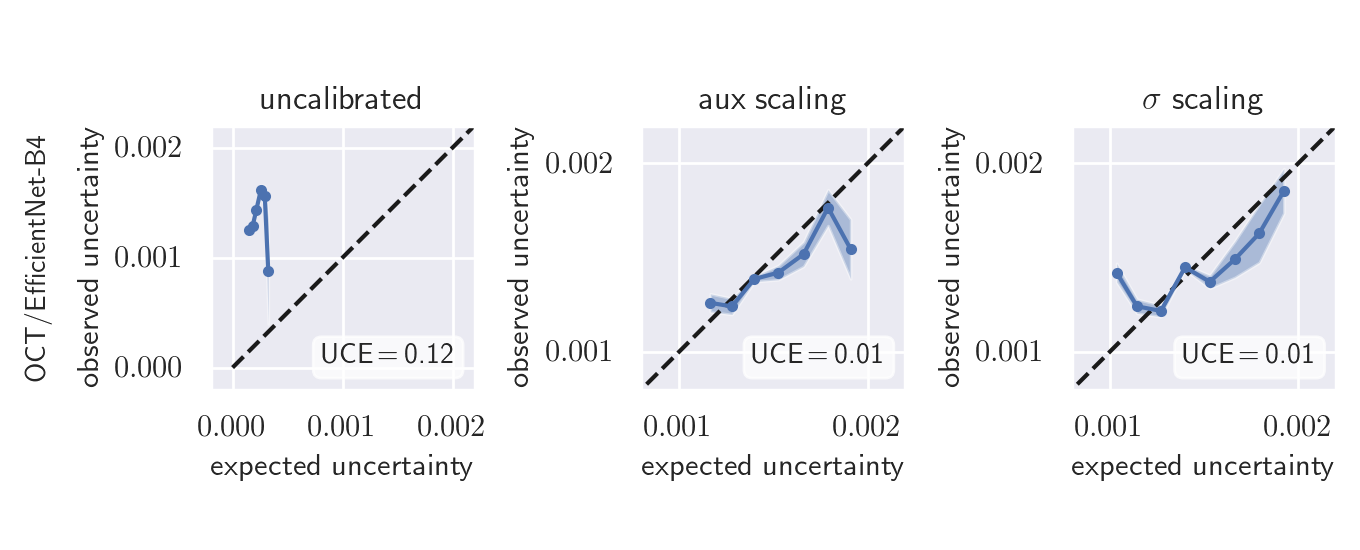

In [100]:
if base_model == 'efficientnetb4':
    fig, ax = plt.subplots(1, 3, figsize=(6.8, 2.75))

    alpha = 0.4
    props = dict(boxstyle='round', facecolor='white', alpha=0.75)

    err_uncal = torch.stack(err_uncal_list).mean(dim=0).cpu()
    err_uncal_var = torch.stack(err_uncal_list).std(dim=0).cpu()
    uncert_uncal = torch.stack(uncert_uncal_list).mean(dim=0).cpu()
    ax[0].plot([0, 0.02], [0, 0.02], 'k--')
    ax[0].plot(uncert_uncal, err_uncal, marker='.', label='uncal')
    ax[0].fill_between(uncert_uncal, err_uncal-err_uncal_var, err_uncal+err_uncal_var, alpha=alpha)
    ax[0].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[0].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[0].set_xlim([-0.0002, 0.0022])
    ax[0].set_ylim([-0.0002, 0.0022])
    ax[0].set_xticks([0, 0.001, 0.002])
    ax[0].set_yticks([0, 0.001, 0.002])
    ax[0].set_aspect(1)
    ax[0].set_title(r'uncalibrated')
    textstr0 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_uncal_list)*100).mean().item())
    ax[0].text(0.925, 0.075, textstr0, transform=ax[0].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_aux = torch.stack(err_aux_list).mean(dim=0).cpu()
    err_aux_var = torch.stack(err_aux_list).std(dim=0).cpu()
    uncert_aux = torch.stack(uncert_aux_list).mean(dim=0).cpu()
    ax[1].plot([0, 0.02], [0, 0.02], 'k--')
    ax[1].plot(uncert_aux, err_aux, marker='.', label='uncal')
    ax[1].fill_between(uncert_aux, err_aux-err_aux_var, err_aux+err_aux_var, alpha=alpha)
    ax[1].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[1].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[1].set_xlim([0.0008, 0.0022])
    ax[1].set_ylim([0.0008, 0.0022])
    ax[1].set_xticks([0.001, 0.002])
    ax[1].set_yticks([0.001, 0.002])
    ax[1].set_aspect(1)
    ax[1].set_title(r'aux scaling')
    textstr1 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_aux_list)*100).mean().item())
    ax[1].text(0.925, 0.075, textstr1, transform=ax[1].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    err_s = torch.stack(err_s_list).mean(dim=0).cpu()
    err_s_var = torch.stack(err_s_list).std(dim=0).cpu()
    uncert_s = torch.stack(uncert_s_list).mean(dim=0).cpu()
    ax[2].plot([0, 0.02], [0, 0.02], 'k--')
    ax[2].plot(uncert_s, err_s, marker='.', label='uncal')
    ax[2].fill_between(uncert_s, err_s-err_s_var, err_s+err_s_var, alpha=alpha)
    ax[2].set_ylabel(r'observed uncertainty', fontsize=11)
    ax[2].set_xlabel(r'expected uncertainty', fontsize=11)
    ax[2].set_xlim([0.0008, 0.0022])
    ax[2].set_ylim([0.0008, 0.0022])
    ax[2].set_xticks([0.001, 0.002])
    ax[2].set_yticks([0.001, 0.002])
    ax[2].set_aspect(1)
    ax[2].set_title(r'$ \sigma $ scaling')
    textstr2 = r'UCE\,=\,{:.2f}'.format((torch.stack(uce_s_list)*100).mean().item())
    ax[2].text(0.925, 0.075, textstr2, transform=ax[2].transAxes, fontsize=10,
                    verticalalignment='bottom',
                    horizontalalignment='right',
                    bbox=props
                    )

    ax[0].annotate(r'OCT/EfficientNet-B4', xy=(0, 0.5), xytext=(-ax[0].yaxis.labelpad - 5, 0),
                   xycoords=ax[0].yaxis.label, textcoords='offset points',
                   size='large', ha='right', va='center', fontsize=10, rotation=90)
    fig.tight_layout()
    fig.show()

    fig.savefig(f"results_levi_oct_{base_model}.pdf", bbox_inches='tight', pad_inches=0.01)
    save_log(base_model)

In [99]:
np.save(f"uce_uncal_levi_oct_{base_model}", np.array([i.detach().numpy() for i in uce_uncal_list]))
np.save(f"err_uncal_levi_oct_{base_model}", np.array([i.detach().numpy() for i in err_uncal_list]))
np.save(f"uncert_uncal_levi_oct_{base_model}", np.array([i.detach().numpy() for i in uncert_uncal_list]))

np.save(f"uce_s_levi_oct_{base_model}", np.array([i.detach().numpy() for i in uce_s_list]))
np.save(f"err_s_levi_oct_{base_model}", np.array([i.detach().numpy() for i in err_s_list]))
np.save(f"uncert_s_levi_oct_{base_model}", np.array([i.detach().numpy() for i in uncert_s_list]))

np.save(f"uce_aux_levi_oct_{base_model}", np.array([i.detach().numpy() for i in uce_aux_list]))
np.save(f"err_aux_levi_oct_{base_model}", np.array([i.detach().numpy() for i in err_aux_list]))
np.save(f"uncert_aux_levi_oct_{base_model}", np.array([i.detach().numpy() for i in uncert_aux_list]))